In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lsda.mcs import *
from lsda.nn import *
from lsda.score import *
from lsda.utils import *

import matplotlib.pyplot as plt 
from tqdm import tqdm

### Generate data

In [3]:
# Initialize data
lorenz = NoisyLorenz63(dt=0.025)

In [4]:
# Generate data
x = lorenz.prior((1024,))
x = lorenz.trajectory(x, length=1024, last=True)
x = lorenz.trajectory(x, length=1024)
x = lorenz.preprocess(x)
x = x.transpose(0, 1)

In [5]:
# Split data
i = int(0.8 * len(x))
j = int(0.9 * len(x))

train_x= x[:i]
val_x= x[i:j]
test_x= x[j:]

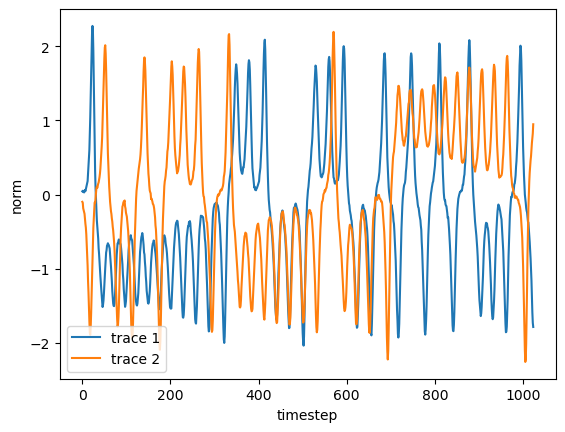

In [6]:
# Visualize testing data
f, ax = plt.subplots()
n_data = 2
dim = 0

for n in range(n_data):
    ax.plot(test_x[n,:,dim], label=f'trace {n+1}');
    ax.set_xlabel('timestep')
    ax.set_ylabel('norm')
    ax.legend();

### Train encoder-decoder

In [7]:
# Dataset construction
input_size = 3
hidden_size = 2
batch_size = 64
window = 1

trainset = TrajectoryDataset(train_x, window=window, flatten=True)
validset = TrajectoryDataset(val_x , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [8]:
# Define hyperparameters
epochs = 256
learning_rate = 1e-3
weight_decay = 1e-3

# Initialize model and optimizer
latent = EncoderDecoder(window*input_size, hidden_size, window*input_size, window)
optimizer = torch.optim.AdamW(latent.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    latent.train()

    for batch in trainloader:
        x, kwargs = batch
    
        z = latent.encoder(x)
        x_ = latent.decoder(z)
        l = (x_ - x).square().mean()
        l.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        losses_train.append(l.detach())

    ## Valid
    latent.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            
            z = latent.encoder(x)
            x_ = latent.decoder(z)
            l = (x_ - x).square().mean()
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())

100%|██████████████████████████████████████████████████████████████████████████████████| 256/256 [00:12<00:00, 20.96it/s]


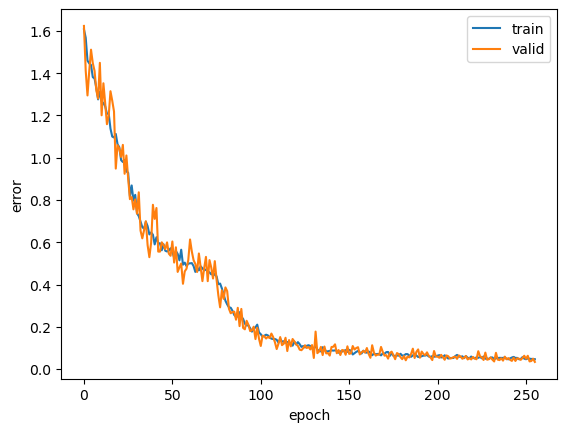

In [9]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Train diffusion model

In [10]:
# Latent dataset creation
input_size = 3
batch_size = 64
window = 5
order = window // 2

trainset = TrajectoryDataset(train_x, window=window, flatten=True)
validset = TrajectoryDataset(val_x , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [11]:
# Network
score = MCScoreNet(
        features=input_size,
        order=order,
        embedding=32,
        hidden_features=[128] * window,
        activation=torch.nn.SiLU
    )

sde = VPSDE(score.kernel, shape=(window*input_size, ))


In [12]:
# diffusion
x, kwargs = next(iter(trainloader))
sde.loss(x, **kwargs)

tensor(1.1538, grad_fn=<MeanBackward0>)

In [13]:
# Defining hyperparemeters
epochs = 256
learning_rate = 1e-3
weight_decay = 1e-3
lr = lambda t: 1 - (t / epochs)

optimizer = torch.optim.AdamW(sde.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    sde.train()
    for batch in trainloader:
        x, kwargs = batch
        
        # compute noise differential loss
        l = sde.loss(x, **kwargs)
        l.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses_train.append(l.detach())

    ## Valid
    sde.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            
            l = sde.loss(x, **kwargs)
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())

    ## Step
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 256/256 [00:43<00:00,  5.84it/s]


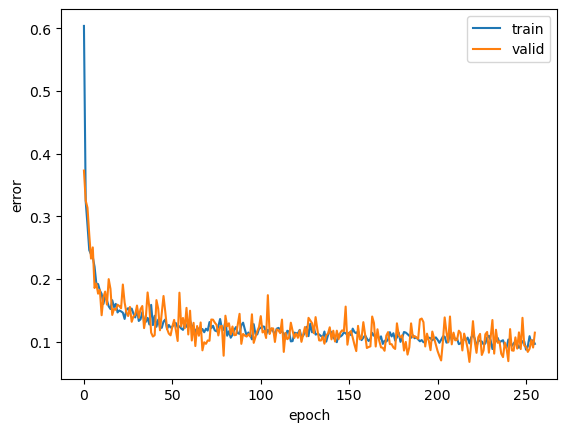

In [14]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Train latent diffusion model

In [15]:
# Latent dataset creation
input_size = hidden_size
batch_size = 64
window = 5
order = window // 2

train_z = latent.encoder(train_x).detach().cpu()
val_z = latent.encoder(val_x).detach().cpu()
test_z = latent.encoder(test_x).detach().cpu()

trainset = TrajectoryDataset(train_z, window=window, flatten=True)
validset = TrajectoryDataset(val_z , window=window, flatten=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)

In [16]:
# Network
score_latent = MCScoreNet(
        features=input_size,
        order=order,
        embedding=32,
        hidden_features=[128] * window,
        activation=torch.nn.SiLU
    )

lsde = VPSDE(score_latent.kernel, shape=(window*input_size, ))


In [17]:
# latent diffusion
x, kwargs = next(iter(trainloader))
lsde.loss(x, **kwargs)

tensor(1.0906, grad_fn=<MeanBackward0>)

In [18]:
# Defining hyperparameters
epochs = 256
learning_rate = 1e-3
weight_decay = 1e-3
lr = lambda t: 1 - (t / epochs)

optimizer = torch.optim.AdamW(lsde.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr)

# Training loop
all_train_losses = []
all_valid_losses = []

for epoch in tqdm(range(epochs)):
    losses_train = []
    losses_valid = []

    lsde.train()
    for batch in trainloader:
        x, kwargs = batch
        
        # compute noise differential loss
        l = lsde.loss(x, **kwargs)
        l.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses_train.append(l.detach())

    ## Valid
    lsde.eval()

    with torch.no_grad():
        for batch in validloader:
            x, kwargs = batch
            
            l = lsde.loss(x, **kwargs)
            
            losses_valid.append(l.detach())

    ## Stats
    all_train_losses.append(torch.stack(losses_train).mean().item())
    all_valid_losses.append(torch.stack(losses_valid).mean().item())

    ## Step
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 256/256 [00:35<00:00,  7.27it/s]


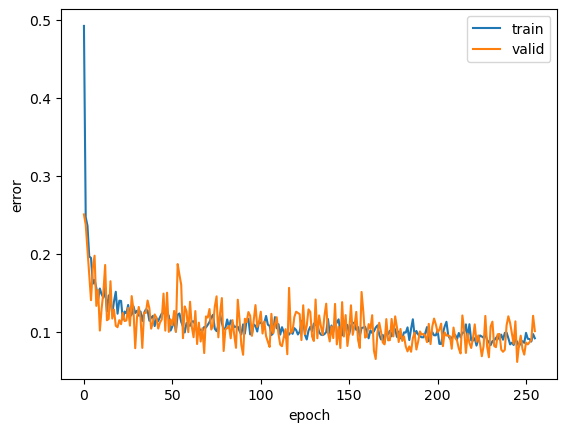

In [19]:
# Plot losses
f, ax = plt.subplots()
ax.plot(np.array(all_train_losses), label='train')
ax.plot(np.array(all_valid_losses), label='valid')
ax.set_xlabel('epoch')
ax.set_ylabel('error')
ax.legend()

### Evaluation

Generate low frequency observations for assimilation (in latent space)

In [29]:
n_states = 65
n_steps = 8
sigma_sq = 0.05
y, yz = test_x[:, :n_states], test_z[:, :n_states]
y_obs, yz_obs = np.random.normal(y[:, ::n_steps, :], sigma_sq), np.random.normal(yz[:, ::n_steps, :], sigma_sq)

In [30]:
n_corrections = 1
all_x_sample = []

# Sampling for diffusion model
sde_eval = VPSDE(
            GaussianScore(
                y=torch.from_numpy(y_obs[0]),
                A=lambda x: x[..., ::n_steps, :],
                std=sigma_sq,
                sde=VPSDE(score, shape=()),
                gamma=3e-2,
                corrected_log=False
            ),
            shape=(n_states, 3)
        )

x_sample = sde_eval.sample((1024,), steps=256, corrections=n_corrections, tau=0.25)
all_x_sample.append(x_sample)


# Sampling from latent diffusion model
lsde_eval = VPSDE(
                GaussianScore(
                    y=torch.from_numpy(yz_obs[0]),
                    A=lambda x: x[..., ::n_steps, :],
                    std=0.05,
                    sde=VPSDE(score_latent, shape=()),
                    gamma=3e-2,
                    corrected_log=False
                ),
                shape=(n_states, 2),
            )

z_sample = lsde_eval.sample((1024,), steps=256, corrections=n_corrections, tau=0.25)
x_sample = latent.decoder(z_sample).detach().cpu()
all_x_sample.append(x_sample)

# Combine all samples
all_x_sample = torch.stack(all_x_sample)

100%|██████████████████████████████████████████████████████████████████████████████████| 256/256 [01:20<00:00,  3.20it/s]


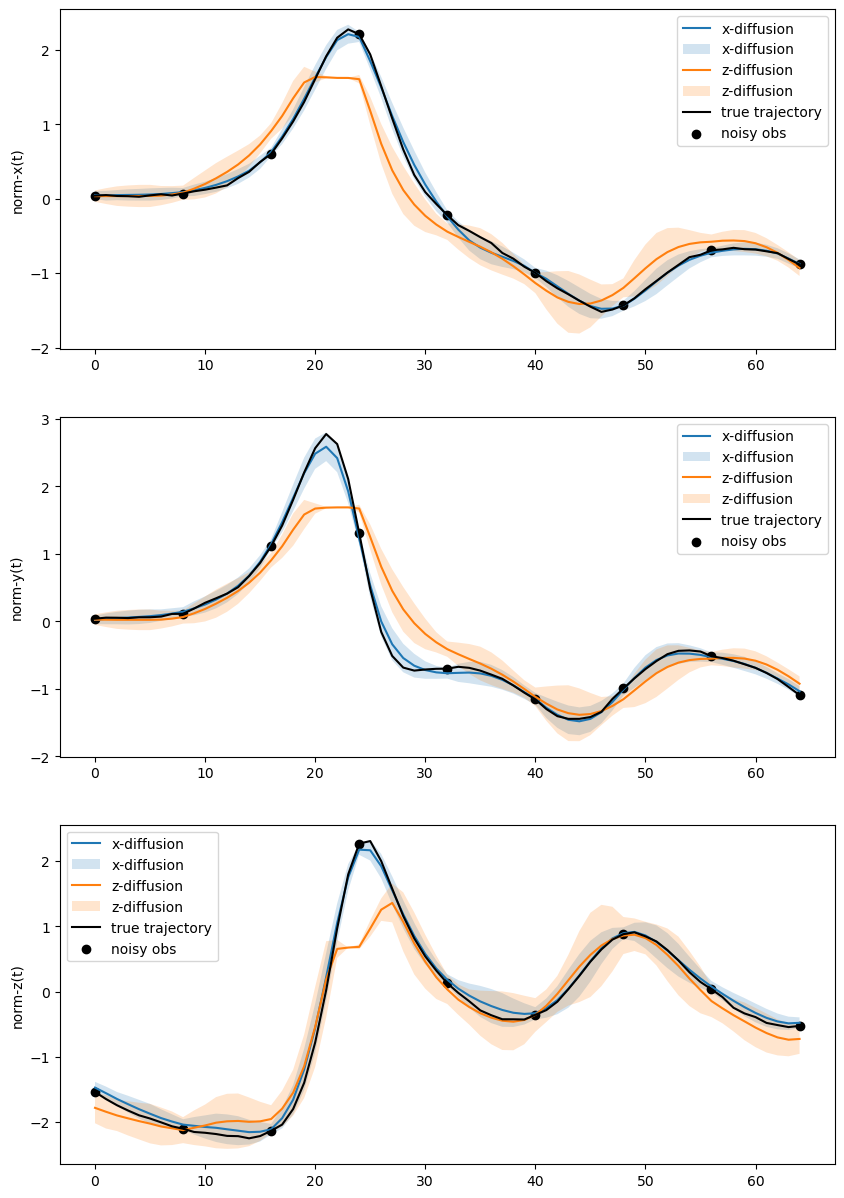

In [36]:
line_labels = ['x-diffusion', 'z-diffusion']
y_labels = ['x(t)', 'y(t)', 'z(t)']

f, ax = plt.subplots(3,1, figsize=(10,15))

for d in range(3):
    for c_idx in range(all_x_sample.shape[0]):
        pred = all_x_sample[c_idx,:,:,d]
        pred_mean, pred_std = pred.mean(axis=0), pred.std(axis=0)
        ax[d].plot(pred_mean, label=line_labels[c_idx])
        ax[d].fill_between(np.arange(n_states), 
                           pred_mean - 2 * pred_std, 
                           pred_mean + 2 * pred_std, 
                           label=line_labels[c_idx],
                           alpha=0.2)
    
    
    ax[d].plot(y[0,:n_states,d], color='black', label='true trajectory')
    
    ax[d].scatter(np.arange(n_states)[::n_steps], y[0,::n_steps,d], color='black', label='noisy obs')
    ax[d].set_ylabel(f'norm-{y_labels[d]}')
    ax[d].legend();

Generate high frequency observations for assimilation (in latent space)

In [23]:
n_states = 65
n_steps = 1
sigma_sq = 0.25
y, yz = test_x[:, :n_states], test_z[:, :n_states]
y_obs, yz_obs = np.random.normal(y[:, ::n_steps, :], sigma_sq), np.random.normal(yz[:, ::n_steps, :], sigma_sq)

In [24]:
n_corrections = 1
all_x_sample = []

# Sampling for diffusion model
sde_eval = VPSDE(
            GaussianScore(
                y=torch.from_numpy(y_obs[0]),
                A=lambda x: x[..., ::n_steps, :],
                std=sigma_sq,
                sde=VPSDE(score, shape=()),
                gamma=3e-2,
                corrected_log=False
            ),
            shape=(n_states, 3)
        )

x_sample = sde_eval.sample((1024,), steps=256, corrections=n_corrections, tau=0.25)
all_x_sample.append(x_sample)


# Sampling from latent diffusion model
lsde_eval = VPSDE(
                GaussianScore(
                    y=torch.from_numpy(yz_obs[0]),
                    A=lambda x: x[..., ::n_steps, :],
                    std=0.05,
                    sde=VPSDE(score_latent, shape=()),
                    gamma=3e-2,
                    corrected_log=False
                ),
                shape=(n_states, 2),
            )

z_sample = lsde_eval.sample((1024,), steps=256, corrections=n_corrections, tau=0.25)
x_sample = latent.decoder(z_sample).detach().cpu()
all_x_sample.append(x_sample)

# Combine all samples
all_x_sample = torch.stack(all_x_sample)

100%|██████████████████████████████████████████████████████████████████████████████████| 256/256 [01:16<00:00,  3.33it/s]


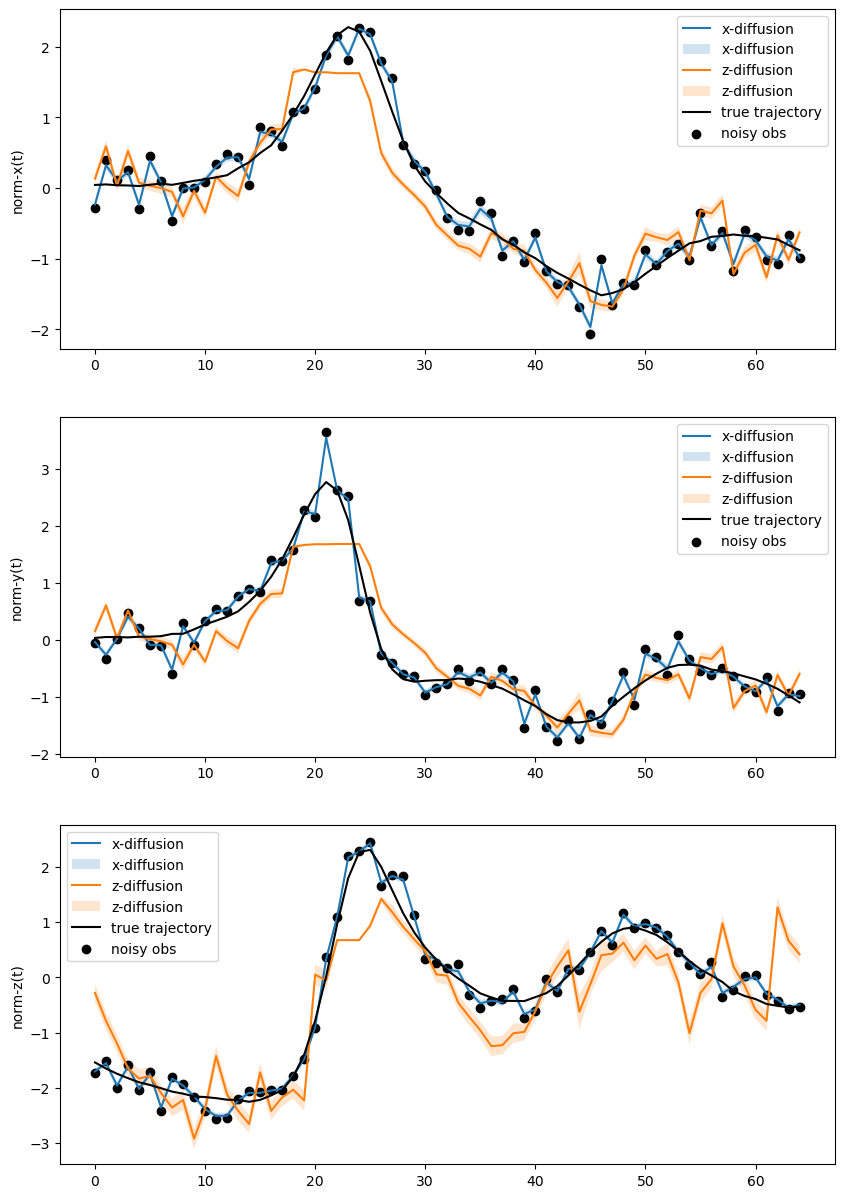

In [28]:
line_labels = ['x-diffusion', 'z-diffusion']
y_labels = ['x(t)', 'y(t)', 'z(t)']

f, ax = plt.subplots(3,1, figsize=(10,15))

for d in range(3):
    for c_idx in range(all_x_sample.shape[0]):
        pred = all_x_sample[c_idx,:,:,d]
        pred_mean, pred_std = pred.mean(axis=0), pred.std(axis=0)
        ax[d].plot(pred_mean, label=line_labels[c_idx])
        ax[d].fill_between(np.arange(n_states), 
                           pred_mean - 2 * pred_std, 
                           pred_mean + 2 * pred_std, 
                           label=line_labels[c_idx],
                           alpha=0.2)
    
    
    ax[d].plot(y[0,:n_states,d], color='black', label='true trajectory')
    
    ax[d].scatter(np.arange(n_states)[::n_steps], y_obs[0,::n_steps,d], color='black', label='noisy obs')
    ax[d].set_ylabel(f'norm-{y_labels[d]}')
    ax[d].legend();